In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load data
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
data = pd.merge(ratings, movies, on='movieId')

In [3]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [4]:
data.shape

(100836, 6)

In [5]:
data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [6]:
# Encode userId and movieId
user_enc = LabelEncoder()
movie_enc = LabelEncoder()
data['user'] = user_enc.fit_transform(data['userId'])
data['movie'] = movie_enc.fit_transform(data['movieId'])

In [8]:
# Save label encoders
import joblib
joblib.dump(user_enc, 'user_encoder.pkl')
joblib.dump(movie_enc, 'movie_encoder.pkl')

['movie_encoder.pkl']

In [7]:
num_users = data['user'].nunique()
num_movies = data['movie'].nunique()

In [9]:
X = data[['user', 'movie']].values
y = data['rating'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, Conv1D, MaxPooling1D, Flatten,
    LSTM, Input, Add
)
from tensorflow.keras.optimizers import Adam


In [12]:
# Store results
results = {}

# Plotting function
def plot_history(history, model_name):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

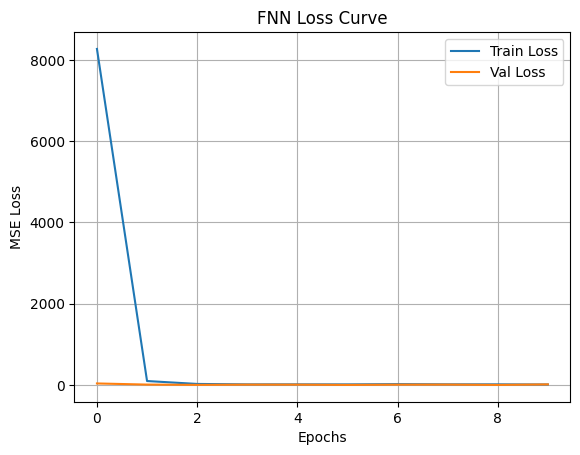

In [13]:
def build_fnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

fnn = build_fnn(X_train.shape[1])
history = fnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
fnn.save('fnn_model.h5')
y_pred = fnn.predict(X_test)
results['FNN'] = r2_score(y_test, y_pred)
plot_history(history, "FNN")

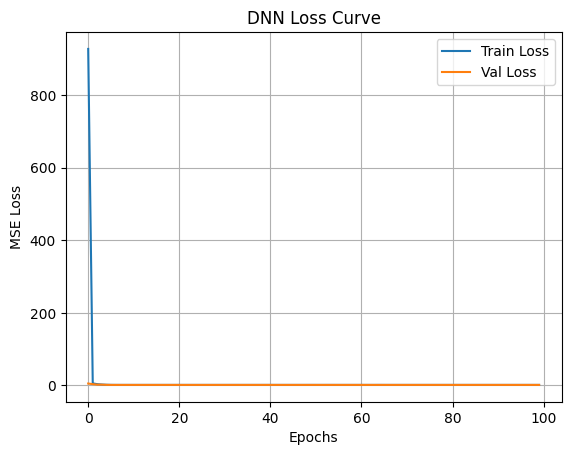

In [28]:
# Model 2: Deep Neural Network (DNN)
def build_dnn(input_dim):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

dnn = build_dnn(X_train.shape[1])
history = dnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128, verbose=0)
dnn.save('dnn_model.h5')
y_pred = dnn.predict(X_test)
results['DNN'] = r2_score(y_test, y_pred)
plot_history(history, "DNN")

In [15]:
# For CNN/LSTM input reshaping
X_train_r = X_train.reshape(-1, X_train.shape[1], 1)
X_test_r = X_test.reshape(-1, X_test.shape[1], 1)

Epoch 1/10
631/631 [==============================] - 5s 6ms/step - loss: 4804.1914 - val_loss: 3.7007
Epoch 2/10
631/631 [==============================] - 3s 5ms/step - loss: 4.1732 - val_loss: 3.3699
Epoch 3/10
631/631 [==============================] - 2s 4ms/step - loss: 3.1971 - val_loss: 3.4703
Epoch 4/10
631/631 [==============================] - 2s 4ms/step - loss: 2.9056 - val_loss: 3.2845
Epoch 5/10
631/631 [==============================] - 2s 3ms/step - loss: 2.6792 - val_loss: 2.5691
Epoch 6/10
631/631 [==============================] - 2s 3ms/step - loss: 2.3363 - val_loss: 3.1820
Epoch 7/10
631/631 [==============================] - 2s 3ms/step - loss: 2.1801 - val_loss: 2.8041
Epoch 8/10
631/631 [==============================] - 2s 3ms/step - loss: 2.7699 - val_loss: 1.4682
Epoch 9/10
631/631 [==============================] - 2s 3ms/step - loss: 2.0408 - val_loss: 1.4261
Epoch 10/10
631/631 [==============================] - 2s 3ms/step - loss: 2.6632 - val_loss: 1.2

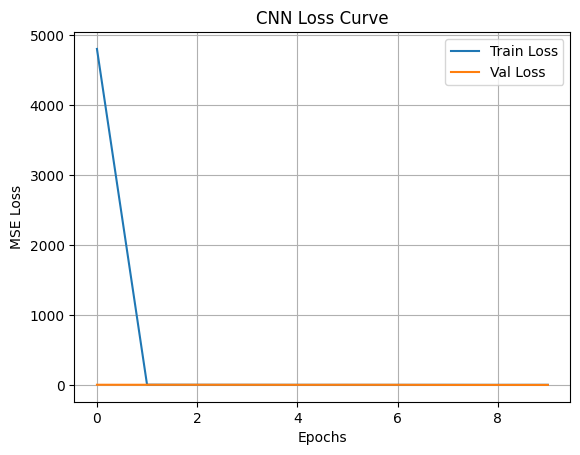

CNN R² Score: -0.1531


In [22]:
# Build CNN model
def build_cnn(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=1, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Train CNN
cnn = build_cnn((X_train.shape[1], 1))
history = cnn.fit(X_train_r, y_train, 
                  validation_data=(X_test_r, y_test), 
                  epochs=10, batch_size=128, verbose=1)
cnn.save('cnn_model.h5')

# Predict and evaluate
y_pred = cnn.predict(X_test_r)
results['CNN'] = r2_score(y_test, y_pred)

# Plot and print results
plot_history(history, "CNN")
print(f"CNN R² Score: {results['CNN']:.4f}")

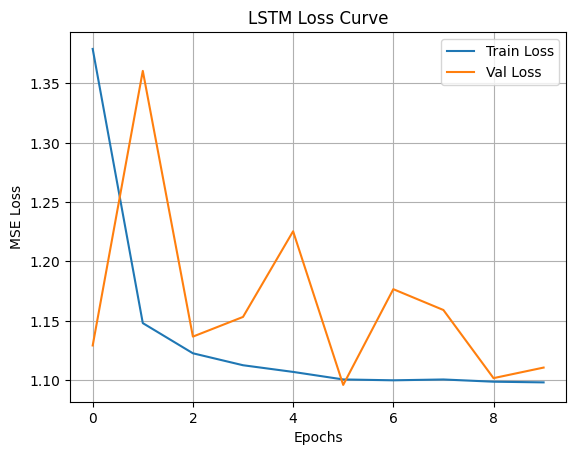

In [23]:
# Model 4: LSTM
def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, input_shape=input_shape),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm = build_lstm((X_train.shape[1], 1))
history = lstm.fit(X_train_r, y_train, validation_data=(X_test_r, y_test), epochs=10, batch_size=128, verbose=0)
lstm.save('lstm_model.h5')
y_pred = lstm.predict(X_test_r)
results['LSTM'] = r2_score(y_test, y_pred)
plot_history(history, "LSTM")

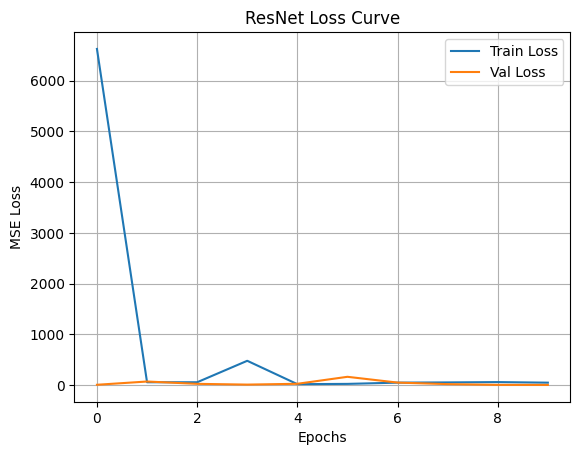


📊 Model R² Scores:
FNN: -12.9671
DNN: 0.0002
CNN: -0.1531
LSTM: -0.0345
ResNet: -0.4829


In [ ]:

# Model 5: ResNet-like model
def build_resnet(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    res = Dense(128)(x)
    x = Add()([x, res])
    x = Dense(64, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

resnet = build_resnet(X_train.shape[1])
history = resnet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, verbose=0)
resnet.save('resnet_model.h5')
y_pred = resnet.predict(X_test)
results['ResNet'] = r2_score(y_test, y_pred)
plot_history(history, "ResNet")

# Print Accuracy (R² Score)
print("\n📊 Model R² Scores:")
for model, score in results.items():
    print(f"{model}: {score:.4f}")

In [25]:
def build_model(embedding_size=50, layers=[128, 64], dropout=0.2):
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))

    user_embedding = Embedding(num_users, embedding_size)(user_input)
    movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

    user_vec = Flatten()(user_embedding)
    movie_vec = Flatten()(movie_embedding)

    concat = Concatenate()([user_vec, movie_vec])
    x = concat

    for layer_size in layers:
        x = Dense(layer_size, activation='relu')(x)
        x = Dropout(dropout)(x)

    output = Dense(1)(x)

    model = Model([user_input, movie_input], output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


In [31]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import r2_score


In [32]:
print("\n🔷 Optimized Shallow Network Model")
model1 = build_model(embedding_size=30, layers=[64, 32])

model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model1.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    batch_size=64,
    epochs=100,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

model1.save('model1_optimized.h5')
y_pred1 = model1.predict([X_test[:, 0], X_test[:, 1]])
print("Optimized Model 1 R² Score:", r2_score(y_test, y_pred1))



🔷 Optimized Shallow Network Model
Epoch 1/100
1261/1261 [==============================] - 39s 13ms/step - loss: 1.6289 - mae: 0.9624 - val_loss: 0.7801 - val_mae: 0.6849 - lr: 0.0010
Epoch 2/100
1261/1261 [==============================] - 11s 8ms/step - loss: 0.9858 - mae: 0.7806 - val_loss: 0.7651 - val_mae: 0.6794 - lr: 0.0010
Epoch 3/100
1261/1261 [==============================] - 11s 9ms/step - loss: 0.8939 - mae: 0.7407 - val_loss: 0.7589 - val_mae: 0.6694 - lr: 0.0010
Epoch 4/100
1261/1261 [==============================] - 12s 9ms/step - loss: 0.8041 - mae: 0.6991 - val_loss: 0.7498 - val_mae: 0.6691 - lr: 0.0010
Epoch 5/100
1261/1261 [==============================] - 11s 9ms/step - loss: 0.7362 - mae: 0.6649 - val_loss: 0.7465 - val_mae: 0.6654 - lr: 0.0010
Epoch 6/100
1261/1261 [==============================] - 12s 9ms/step - loss: 0.6840 - mae: 0.6377 - val_loss: 0.7522 - val_mae: 0.6634 - lr: 0.0010
Epoch 7/100
1261/1261 [==============================] - 12s 9ms/step 